In [ ]:
!pip list

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Load dataset


In [1]:
ds_dir = pathlib.Path("datasets/flowers/")

or

In [3]:
import pathlib

ds_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
ds_file = tf.keras.utils.get_file('flower_photos.tar', origin=ds_url, extract=True)
ds_dir = pathlib.Path(ds_file).with_suffix('')

228813984/228813984 [==============================] - 8s 0us/step


# Working with DS

In [4]:
image_count = len(list(ds_dir.glob("*/*.jpg")))
print(f"Image count: {image_count}")

Image count: 3670


In [5]:
batch_size = 32
img_height, img_width = 180, 180
img_size = (img_height, img_width)

Create training DS

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=ds_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [7]:
class_names = train_ds.class_names
print(f"Class names: {class_names}")

Class names: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


Create validation DS

In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=ds_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


Caching

In [12]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Create model

In [13]:
from keras.api._v2.keras import activations
num_classes = len(class_names)
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

Compile model

In [14]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

Print model summary

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

# Train model

In [17]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 119s 1s/step - loss: 1.4259 - accuracy: 0.4063 - val_loss: 1.1611 - val_accuracy: 0.5218
Epoch 2/10
92/92 [==============================] - 106s 1s/step - loss: 1.0651 - accuracy: 0.5766 - val_loss: 1.0409 - val_accuracy: 0.6049
Epoch 3/10
92/92 [==============================] - 104s 1s/step - loss: 0.8740 - accuracy: 0.6594 - val_loss: 0.9059 - val_accuracy: 0.6499
Epoch 4/10
92/92 [==============================] - 108s 1s/step - loss: 0.6808 - accuracy: 0.7493 - val_loss: 0.9401 - val_accuracy: 0.6567
Epoch 5/10
92/92 [==============================] - 106s 1s/step - loss: 0.4679 - accuracy: 0.8290 - val_loss: 1.1787 - val_accuracy: 0.6308
Epoch 6/10
92/92 [==============================] - 107s 1s/step - loss: 0.3248 - accuracy: 0.8883 - val_loss: 1.1201 - val_accuracy: 0.6403
Epoch 7/10
92/92 [==============================] - 109s 1s/step - loss: 0.1603 - accuracy: 0.9486 - val_loss: 1.4745 - val_accuracy: 0.6308
Epoch 8/10
92

Visualize training and validation results

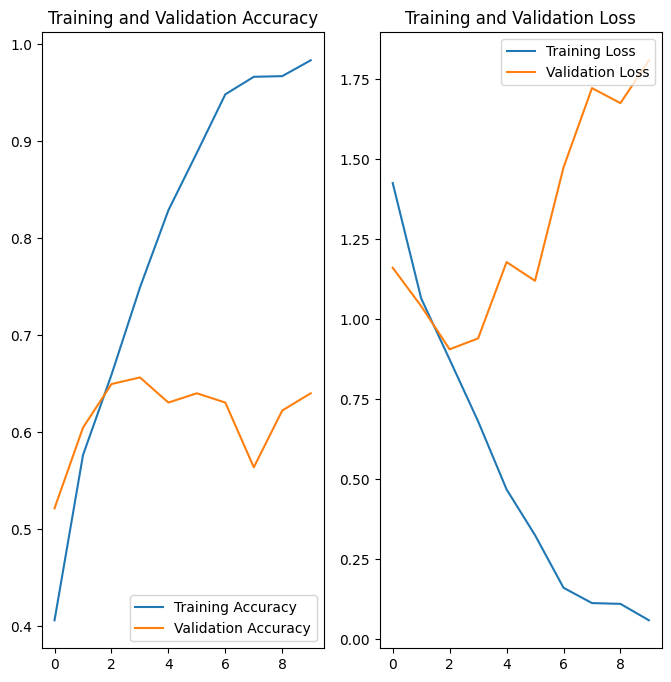

In [18]:
# visualize training and validation results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Solving the problem of overfitting

Adding augmentation and regularization (Dropout)

In [19]:
model = Sequential([
	layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

	# augmentation
	layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
	layers.experimental.preprocessing.RandomRotation(0.1),
	layers.experimental.preprocessing.RandomZoom(0.1),
	layers.experimental.preprocessing.RandomContrast(0.2),

	layers.Conv2D(16, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Conv2D(32, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Conv2D(64, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	# regularization
	layers.Dropout(0.2),

	layers.Flatten(),
	layers.Dense(128, activation='relu'),
	layers.Dense(num_classes)
])

# compile the model
model.compile(
	optimizer='adam',
	loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
	metrics=['accuracy'])

# print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 180, 180, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 180, 180, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 180, 180, 3)       0         
                                                                 
 random_contrast (RandomCont  (None, 180, 180, 3)      0         
 rast)                                                           
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)     

Retraining the neural network with new layers and more training epochs

In [20]:
# train the model
epochs = 20
history = model.fit(
	train_ds,
	validation_data=val_ds,
	epochs=epochs)

Epoch 1/20
92/92 [==============================] - 128s 1s/step - loss: 1.4134 - accuracy: 0.4019 - val_loss: 1.2007 - val_accuracy: 0.4850
Epoch 2/20
92/92 [==============================] - 122s 1s/step - loss: 1.1149 - accuracy: 0.5559 - val_loss: 1.0118 - val_accuracy: 0.5804
Epoch 3/20
92/92 [==============================] - 118s 1s/step - loss: 0.9983 - accuracy: 0.6073 - val_loss: 0.9644 - val_accuracy: 0.6294
Epoch 4/20
92/92 [==============================] - 122s 1s/step - loss: 0.9453 - accuracy: 0.6407 - val_loss: 0.9312 - val_accuracy: 0.6281
Epoch 5/20
92/92 [==============================] - 119s 1s/step - loss: 0.8746 - accuracy: 0.6563 - val_loss: 0.8721 - val_accuracy: 0.6580
Epoch 6/20
92/92 [==============================] - 124s 1s/step - loss: 0.8126 - accuracy: 0.6931 - val_loss: 0.8589 - val_accuracy: 0.6403
Epoch 7/20
92/92 [==============================] - 123s 1s/step - loss: 0.7790 - accuracy: 0.7084 - val_loss: 0.8421 - val_accuracy: 0.6798
Epoch 8/20
92

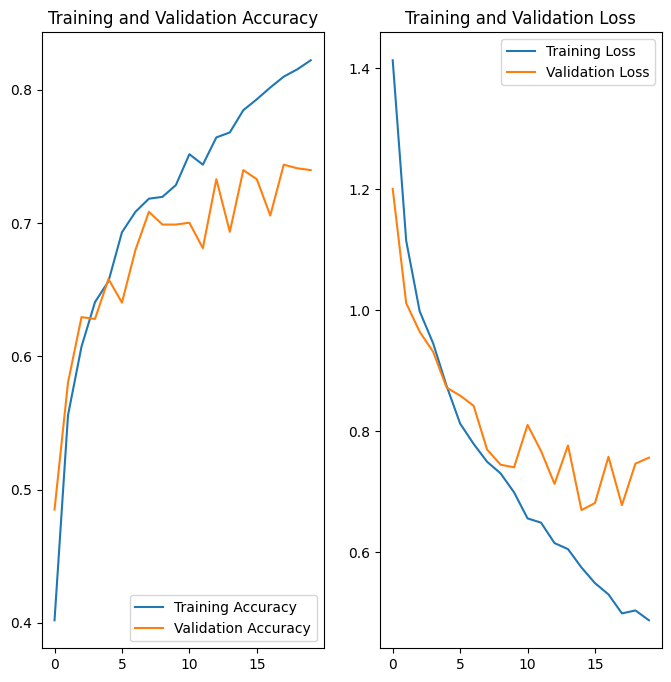

In [21]:
# visualize training and validation results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Making inference on a new image

Load model if need (NOT WORKING, NEED FINISHING)

In [ ]:
# load model
model.load_weights("TF_FlowersClassificationModel")

loss, acc = model.evaluate(train_ds, verbose=2)
print("Restored model, accurasy: {:5.2f}%".format(100 * acc))

Model test

In [22]:
# load image
flower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg" # sunflower

or

In [28]:
flower_url = "https://uralsad74.ru/upload/iblock/8f8/rhujuj5ubqfhdy1n3hdarop2k2ccd0nr.jpg" #

In [29]:
flower_path = tf.keras.utils.get_file('flower2', origin=flower_url)

img = tf.keras.utils.load_img(
    flower_path, target_size=img_size
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

263662/263662 [==============================] - 1s 3us/step


In [30]:
# make predictions
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# print inference result
print("Image contains '{}' ({:.2f}% probability)".format(
	class_names[np.argmax(score)],
	100 * np.max(score))
)

# show the image itself
img.show()

1/1 [==============================] - 0s 34ms/step
Image contains 'roses' (97.00% probability)


# Export model file (download to your computer)

In [31]:
from google.colab import files

model_file_name = "TF_FlowersClassificationModel.h5"

# save model
model.save(model_file_name)

# download model
files.download(model_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>